# Feature Engineering for Student Education with PCA

In this assessment, you'll continue working with the [U.S. Education dataset](https://www.kaggle.com/noriuk/us-education-datasets-unification-project/) from Kaggle. The data gives detailed, state-level information on the several facets of the state of education on annual basis. To learn more about the data and the column descriptions, you can view the Kaggle link above. You can access the data from the Thinkful database.

We will start by importing relevant libraries.

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
import warnings
import seaborn as sns

from scipy.stats import zscore
from scipy.stats.mstats import winsorize

import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')
# Display up to 500 columns of a wide dataframe, instead of using ...
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

with engine.begin() as conn:
    query = text("""SELECT * FROM useducation""")
    education_df = pd.read_sql_query(query, conn)

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

We will use the following helper functions.

In [2]:
# Pass in a dataframe, a list of columns to interpolate, and the limit direction.
# Loop through all of the columns and interpolate.
# Return the updated dataframe.
def interpolate_missing(df,key_column,column_list,limit_dir,**kwargs):
    interp_how = kwargs.get('interp_how','linear')
    for each_value in df[key_column].unique():
        for column in column_list:
            mask = (df[key_column] == each_value)
            df.loc[mask, column] = df.loc[mask, column].interpolate(limit_direction=limit_dir,method=interp_how)
    return df

Let's do some data cleaning. We will follow the same steps as before.

In [4]:
# There are a lot of entries from US territories that are mostly NaNs and
# which don't have the full complement of data the states have--
# the only populated columns in most of these rows are for GRADES_*.
# These rows aren't particularly useful otherwise, so let's just drop them.

state_counts = education_df['STATE'].value_counts()

# A full complement of data for a state is 26 rows/years.
to_remove = state_counts[state_counts < 26].index

# Keep rows in the df where the state is not on the list to_remove
education_df = education_df[~education_df['STATE'].isin(to_remove)]

In [5]:
# Interpolate missing values
education_df = interpolate_missing(education_df,
                                     'STATE',
                                     ['ENROLL',
                                      'OTHER_EXPENDITURE',
                                      'GRADES_PK_G',
                                      'GRADES_KG_G',
                                      'GRADES_4_G',
                                      'GRADES_8_G',
                                      'GRADES_12_G',
                                      'GRADES_1_8_G',
                                      'GRADES_9_12_G',
                                      'GRADES_ALL_G'
                                     ],
                                     'both')

In [6]:
for this_state in education_df['STATE'].unique():
    print("Interpolating scores for {}".format(this_state))
    education_df = interpolate_missing(education_df,
                                         'STATE',
                                         ['AVG_MATH_4_SCORE',
                                          'AVG_MATH_8_SCORE',
                                          'AVG_READING_4_SCORE',
                                          'AVG_READING_8_SCORE'
                                         ],
                                         'both',interp_how='linear')

Interpolating scores for ALABAMA
Interpolating scores for ALASKA
Interpolating scores for ARIZONA
Interpolating scores for ARKANSAS
Interpolating scores for CALIFORNIA
Interpolating scores for COLORADO
Interpolating scores for CONNECTICUT
Interpolating scores for DELAWARE
Interpolating scores for DISTRICT_OF_COLUMBIA
Interpolating scores for FLORIDA
Interpolating scores for GEORGIA
Interpolating scores for HAWAII
Interpolating scores for IDAHO
Interpolating scores for ILLINOIS
Interpolating scores for INDIANA
Interpolating scores for IOWA
Interpolating scores for KANSAS
Interpolating scores for KENTUCKY
Interpolating scores for LOUISIANA
Interpolating scores for MAINE
Interpolating scores for MARYLAND
Interpolating scores for MASSACHUSETTS
Interpolating scores for MICHIGAN
Interpolating scores for MINNESOTA
Interpolating scores for MISSISSIPPI
Interpolating scores for MISSOURI
Interpolating scores for MONTANA
Interpolating scores for NEBRASKA
Interpolating scores for NEVADA
Interpolati

In [7]:
# Except for AVG scores, rows with a year == 2017 have all NaNs in other columns.
# We've interpolated the AVG columns and so have made use of the 2017 rows
# where those columns are populated, so let's drop 2017 now.
education_df = education_df[education_df['YEAR'] != 2017]

Let's verify that all of the NaNs have been dealt with:

In [8]:
# The sum of null rows for each column * 100, divided by the total number of rows for each column:
education_df.isnull().sum()*100/education_df.isnull().count()

PRIMARY_KEY                     0.0
STATE                           0.0
YEAR                            0.0
ENROLL                          0.0
TOTAL_REVENUE                   0.0
FEDERAL_REVENUE                 0.0
STATE_REVENUE                   0.0
LOCAL_REVENUE                   0.0
TOTAL_EXPENDITURE               0.0
INSTRUCTION_EXPENDITURE         0.0
SUPPORT_SERVICES_EXPENDITURE    0.0
OTHER_EXPENDITURE               0.0
CAPITAL_OUTLAY_EXPENDITURE      0.0
GRADES_PK_G                     0.0
GRADES_KG_G                     0.0
GRADES_4_G                      0.0
GRADES_8_G                      0.0
GRADES_12_G                     0.0
GRADES_1_8_G                    0.0
GRADES_9_12_G                   0.0
GRADES_ALL_G                    0.0
AVG_MATH_4_SCORE                0.0
AVG_MATH_8_SCORE                0.0
AVG_READING_4_SCORE             0.0
AVG_READING_8_SCORE             0.0
dtype: float64

#### Q1. Create a new score variable from the weighted averages of all score variables in the datasets. Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores.

This is a weighted score.

- The weight for 4th graders is: `GRADES_4_G / (GRADES_4_G + GRADES_8_G)`
- The weight for 8th graders is: `GRADES_8_G / (GRADES_4_G + GRADES_8_G)`

In [9]:
# Calculate weights for 4th grade and 8th grade
education_df['4G_W'] = education_df['GRADES_4_G'] / (education_df['GRADES_4_G'] + education_df['GRADES_8_G'])
education_df['8G_W'] = education_df['GRADES_8_G'] / (education_df['GRADES_4_G'] + education_df['GRADES_8_G'])

# Calculate weighted averages for 4th graders and 8th graders
education_df['WEIGHTED_AVG_SCORE4'] = ((education_df['AVG_MATH_4_SCORE'] + education_df['AVG_READING_4_SCORE']) * education_df['4G_W']) / 2
education_df['WEIGHTED_AVG_SCORE8'] = ((education_df['AVG_MATH_8_SCORE'] + education_df['AVG_READING_8_SCORE']) * education_df['8G_W']) / 2

# Add weighted averages together to get overall weighted average
education_df['WEIGHTED_AVG_SCORE'] = education_df['WEIGHTED_AVG_SCORE4'] + education_df['WEIGHTED_AVG_SCORE8']

In [10]:
education_df[['4G_W','8G_W','WEIGHTED_AVG_SCORE4','WEIGHTED_AVG_SCORE8','WEIGHTED_AVG_SCORE']]

,4G_W,8G_W,WEIGHTED_AVG_SCORE4,WEIGHTED_AVG_SCORE8,WEIGHTED_AVG_SCORE
0,0.499668,0.500332,104.003749,128.201053,232.204803
1,0.525867,0.474133,114.476187,127.186788,241.662975
2,0.530388,0.469612,111.770484,123.868586,235.639070
3,0.490240,0.509760,102.666108,132.775175,235.441283
4,0.535257,0.464743,108.433295,123.177701,231.610996
...,...,...,...,...,...
1281,0.507149,0.492851,111.042295,134.317102,245.359397
1282,0.502349,0.497651,115.147852,135.387188,250.535040
1283,0.501512,0.498488,117.157496,134.671959,251.829455
1284,0.521645,0.478355,121.956511,131.832791,253.789302


In [13]:
# We can drop the unneeded variables
education_df.drop(['4G_W','8G_W','WEIGHTED_AVG_SCORE4','WEIGHTED_AVG_SCORE8'],axis='columns',inplace=True)

In [14]:
education_df.describe()

,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,WEIGHTED_AVG_SCORE
count,1280.000000,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1.280000e+03,1.280000e+03,1.280000e+03,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000
mean,2004.017969,9.116706e+05,9.092082e+06,7.663723e+05,4.216553e+06,4.109157e+06,9.196681e+06,4.762966e+06,2.680331e+06,4.222320e+05,9.027693e+05,19038.937500,69664.090234,70485.978906,70194.607422,59614.644141,5.668963e+05,2.706240e+05,8.565999e+05,232.363697,277.075636,218.320324,262.958175,247.661491
std,7.205711,1.060012e+06,1.174519e+07,1.145242e+06,5.543072e+06,5.482971e+06,1.197813e+07,6.293004e+06,3.353349e+06,5.278970e+05,1.327562e+06,30686.330588,82275.301785,82249.043359,80702.085178,69833.118559,6.585042e+05,3.152977e+05,9.968944e+05,10.587956,10.263288,7.834835,6.073342,7.518495
min,1992.000000,4.386600e+04,4.656500e+05,3.102000e+04,0.000000e+00,2.209300e+04,4.816650e+05,2.655490e+05,1.399630e+05,1.154100e+04,1.270800e+04,0.000000,3459.000000,2548.000000,1485.000000,484.000000,1.922600e+04,2.758000e+03,2.455400e+04,187.134670,232.831510,178.557612,236.379102,210.794614
25%,1998.000000,2.533458e+05,2.186305e+06,1.893540e+05,1.153097e+06,7.158345e+05,2.165404e+06,1.168032e+06,6.357900e+05,9.902825e+04,1.815645e+05,2594.500000,19891.000000,19686.750000,20119.500000,17059.750000,1.590518e+05,7.626500e+04,2.357432e+05,225.509728,271.173255,214.193624,259.159480,243.700154
50%,2004.000000,6.472755e+05,5.079546e+06,4.033765e+05,2.537074e+06,2.055780e+06,5.234506e+06,2.657452e+06,1.525406e+06,2.658320e+05,5.102595e+05,9403.500000,48757.000000,49305.500000,49427.500000,39663.500000,4.001715e+05,1.817525e+05,6.050375e+05,233.551337,278.829503,220.028740,264.072770,248.734904
75%,2010.000000,1.006750e+06,1.085985e+07,8.289660e+05,5.080939e+06,4.768680e+06,1.074519e+07,5.568028e+06,3.229651e+06,5.102788e+05,9.668515e+05,24263.500000,79396.000000,79093.250000,80452.250000,70630.000000,6.385595e+05,3.127090e+05,9.669560e+05,240.621706,283.982830,223.659162,267.294955,252.938868
max,2016.000000,6.307022e+06,8.921726e+07,9.990221e+06,5.090457e+07,3.610526e+07,8.532013e+07,4.396452e+07,2.605802e+07,3.995951e+06,1.022366e+07,250911.000000,530531.000000,493415.000000,500143.000000,498403.000000,3.929869e+06,2.013687e+06,5.944746e+06,253.420961,300.568235,236.773867,277.191363,264.696429


#### Q2. What are the correlations between this newly created score variable and the expenditure types? Which one of the expenditure types is more correlated than the others?

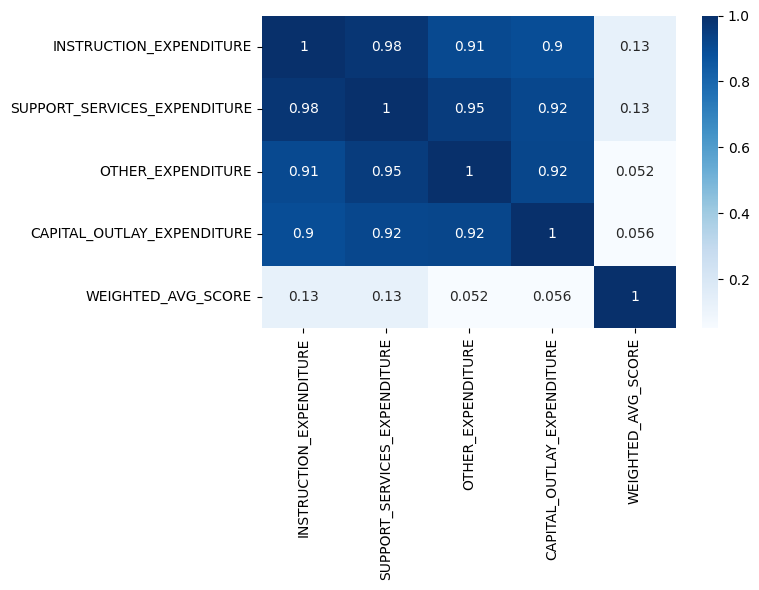

In [20]:
education_df_exp_vs_score = education_df[['INSTRUCTION_EXPENDITURE',
                                'SUPPORT_SERVICES_EXPENDITURE',
                                'OTHER_EXPENDITURE',
                                'CAPITAL_OUTLAY_EXPENDITURE',
                                'WEIGHTED_AVG_SCORE']]


fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(education_df_exp_vs_score.corr(), cmap='Blues', annot=True, ax=ax)

plt.tight_layout()
plt.show()


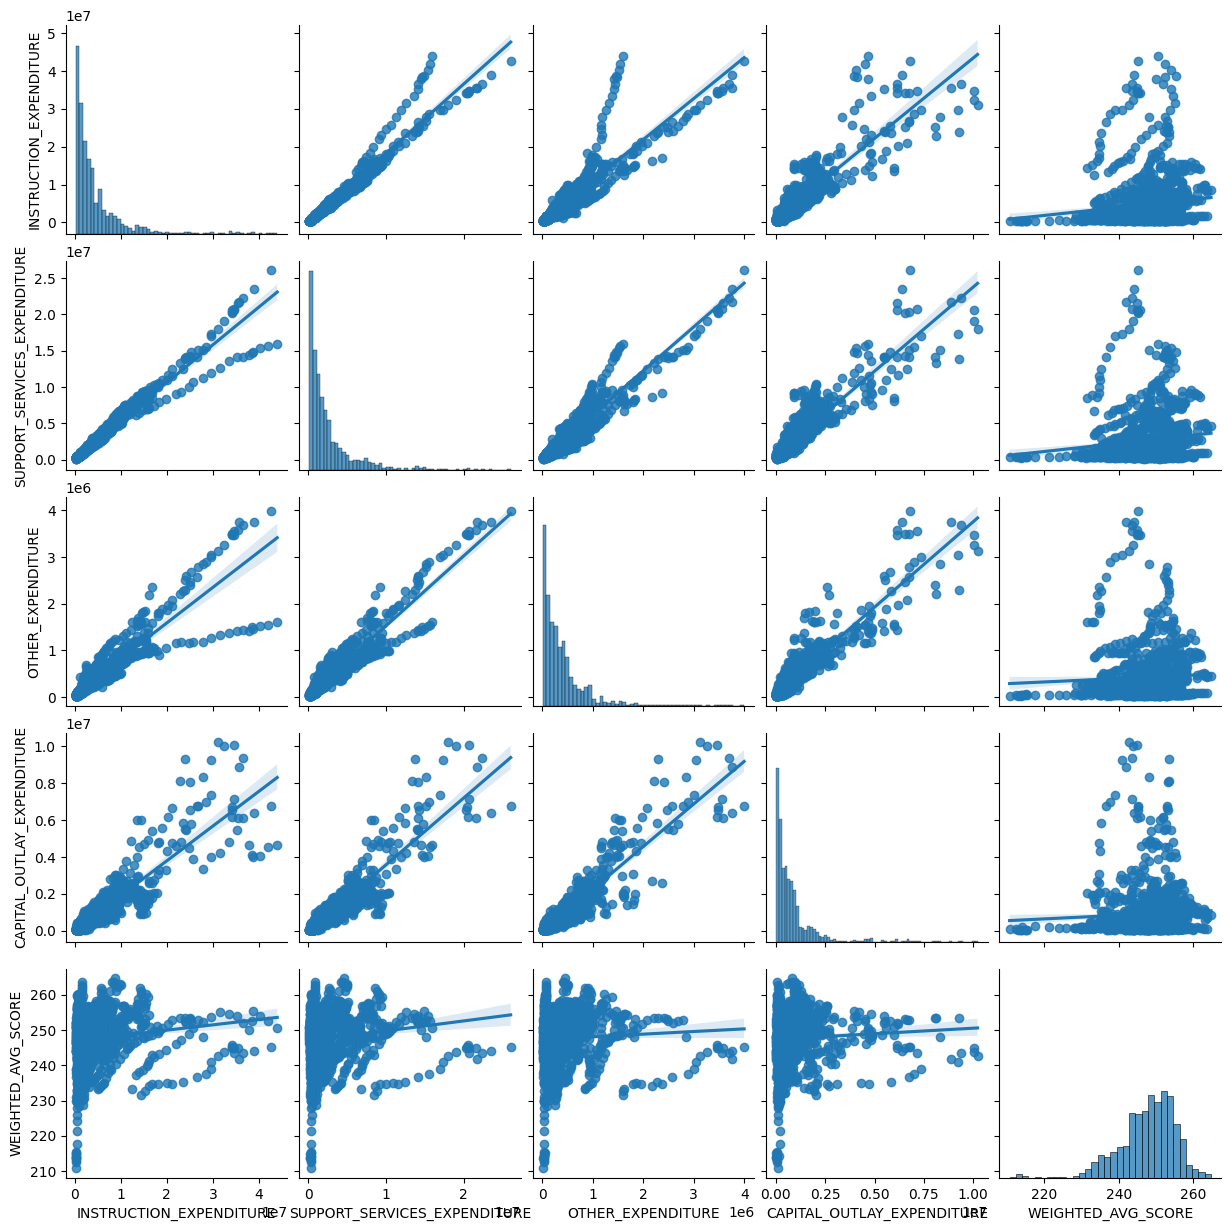

In [21]:
sns.pairplot(education_df_exp_vs_score,kind='reg')

The two highest correlated values for `WEIGHTED_AVG_SCORE` are  `SUPPORT_SERVICES_EXPENDITURE` and `INSTRUCTION_EXPENDITURE`.

#### Q3: Now, apply PCA to the four expenditure types. How much of the total variance is explained by the first component?

First, let's do this by hand as explained in the lesson. Our first step is to create a covariance matrix--this is how we determine how closely the variances of these variables match.

In [24]:
education_df_exp = education_df[['INSTRUCTION_EXPENDITURE',
                        'SUPPORT_SERVICES_EXPENDITURE',
                        'OTHER_EXPENDITURE',
                        'CAPITAL_OUTLAY_EXPENDITURE']]

Then we will normalize and visualize our covariance matrix.

In [25]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(education_df_exp)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[1.00078186 0.97765258 0.91026466 0.89680376]
 [0.97765258 1.00078186 0.95373397 0.91849912]
 [0.91026466 0.95373397 1.00078186 0.9221848 ]
 [0.89680376 0.91849912 0.9221848  1.00078186]]


Next, we will calculate eigenvectors and eigenvalues, which allow us to better understand how to transform the covariance matrix.

In [26]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[-0.49943052 -0.50803207 -0.49952747 -0.49289439]
Eigenvalue 1: 3.790780770753682
----------------------------------------
Eigenvector 2: 
[-0.53418934  0.79173316 -0.29529702  0.0244953 ]
Eigenvalue 2: 0.01384900753103163
----------------------------------------
Eigenvector 3: 
[-0.59012268 -0.33063993  0.23882593  0.69670269]
Eigenvalue 3: 0.12138943153250108
----------------------------------------
Eigenvector 4: 
[ 0.34200312 -0.07575786 -0.7786104   0.52063468]
Eigenvalue 4: 0.07710823349787788
----------------------------------------
The percentage of total variance in the dataset explained by each component calculated by hand.
 [0.94695481 0.00345955 0.03032365 0.019262  ]


The highest-correlated component will explain about 94.7% of the overall data's variance. Next, we visualize the data through the *scree plot*.

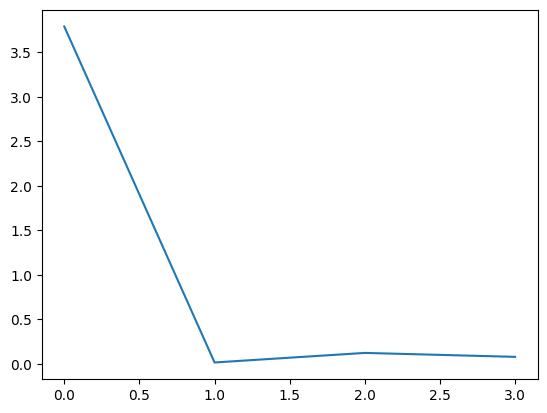

[3.79078077 0.01384901 0.12138943 0.07710823]


In [27]:
# print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

This tells use that once again the majority of the variance is inside the first component. We could have simplied these steps by using functions from Matplotlib and scikit-learn.

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.94695481 0.03032365 0.019262   0.00345955]


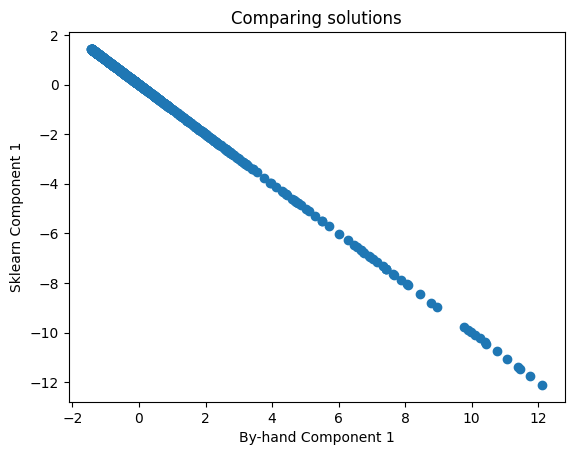

In [29]:
sklearn_pca = PCA(n_components=4)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

#### Q4: What is the correlation between the overall score variable and the first principal component?

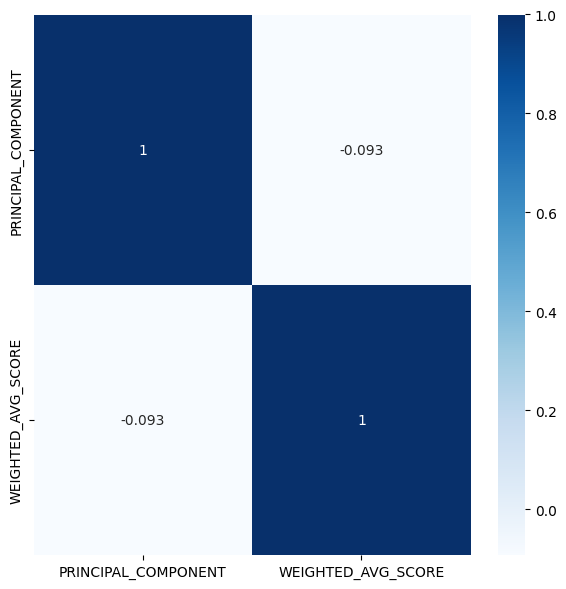

In [38]:
education_df['PRINCIPAL_COMPONENT'] = Y

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(education_df[['PRINCIPAL_COMPONENT','WEIGHTED_AVG_SCORE']].corr(), cmap='Blues', annot=True, ax=ax)

plt.tight_layout()
plt.show()


It is low, approximately -9.31%. Plotting the columns confirms this relationship.

<Axes: xlabel='PRINCIPAL_COMPONENT', ylabel='WEIGHTED_AVG_SCORE'>

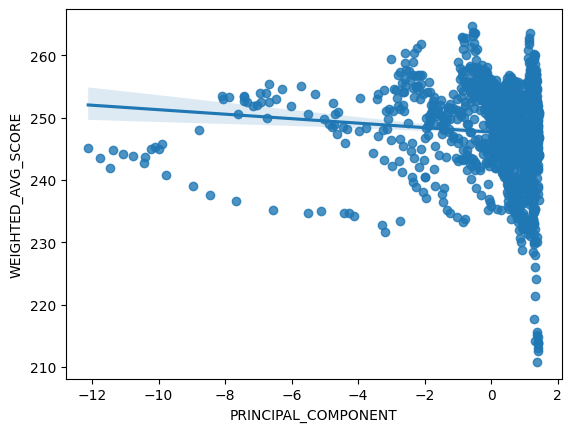

In [39]:
sns.regplot(data=education_df,
            y='WEIGHTED_AVG_SCORE',
            x='PRINCIPAL_COMPONENT')

#### Q5: If you were to choose the best variables for your model, would you prefer using the first principal component instead of the expenditure variables? Why?

- **Pros:** Reducing the number of variables helps mitigate the curse of multidimensionality--fewer numbers to crunch, requiring fewer resources to model.

- **Cons:** You can't be completely sure which variables make up the principal component, so if you are looking for some direct relationships between variables, they will be difficult to see.